# Markov Chain Monte Carlo
In this notebook we will learn about Markov Chain Monte Carlo (MCMC) and how we can do it in Python! This notebook compliments the slide presentation on this subject and will contain minimal text sections here.

## Some initialization...

In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

Use a constant random seed so that we all generate the same random data.

## Generate the data

In [2]:
# Set the true values of model parameters...
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate the fake data to work with...
N = 50 # Number of data points
x = np.sort(10 * np.random.rand(N)) # x-values between 0 and 10
yerr = 0.1 + 0.5*np.random.rand(N)
y = m_true*x + b_true
y += np.abs(f_true*y) * np.random.normal(0.0, 1.0, N)
y += yerr*np.random.normal(0.0, 1.0, N)

Basically, we created some linear data and add a bunch of noise to it as well as adding in some errors that we don't fully trust in our data.

We can plot the data to see what it looks like right now,

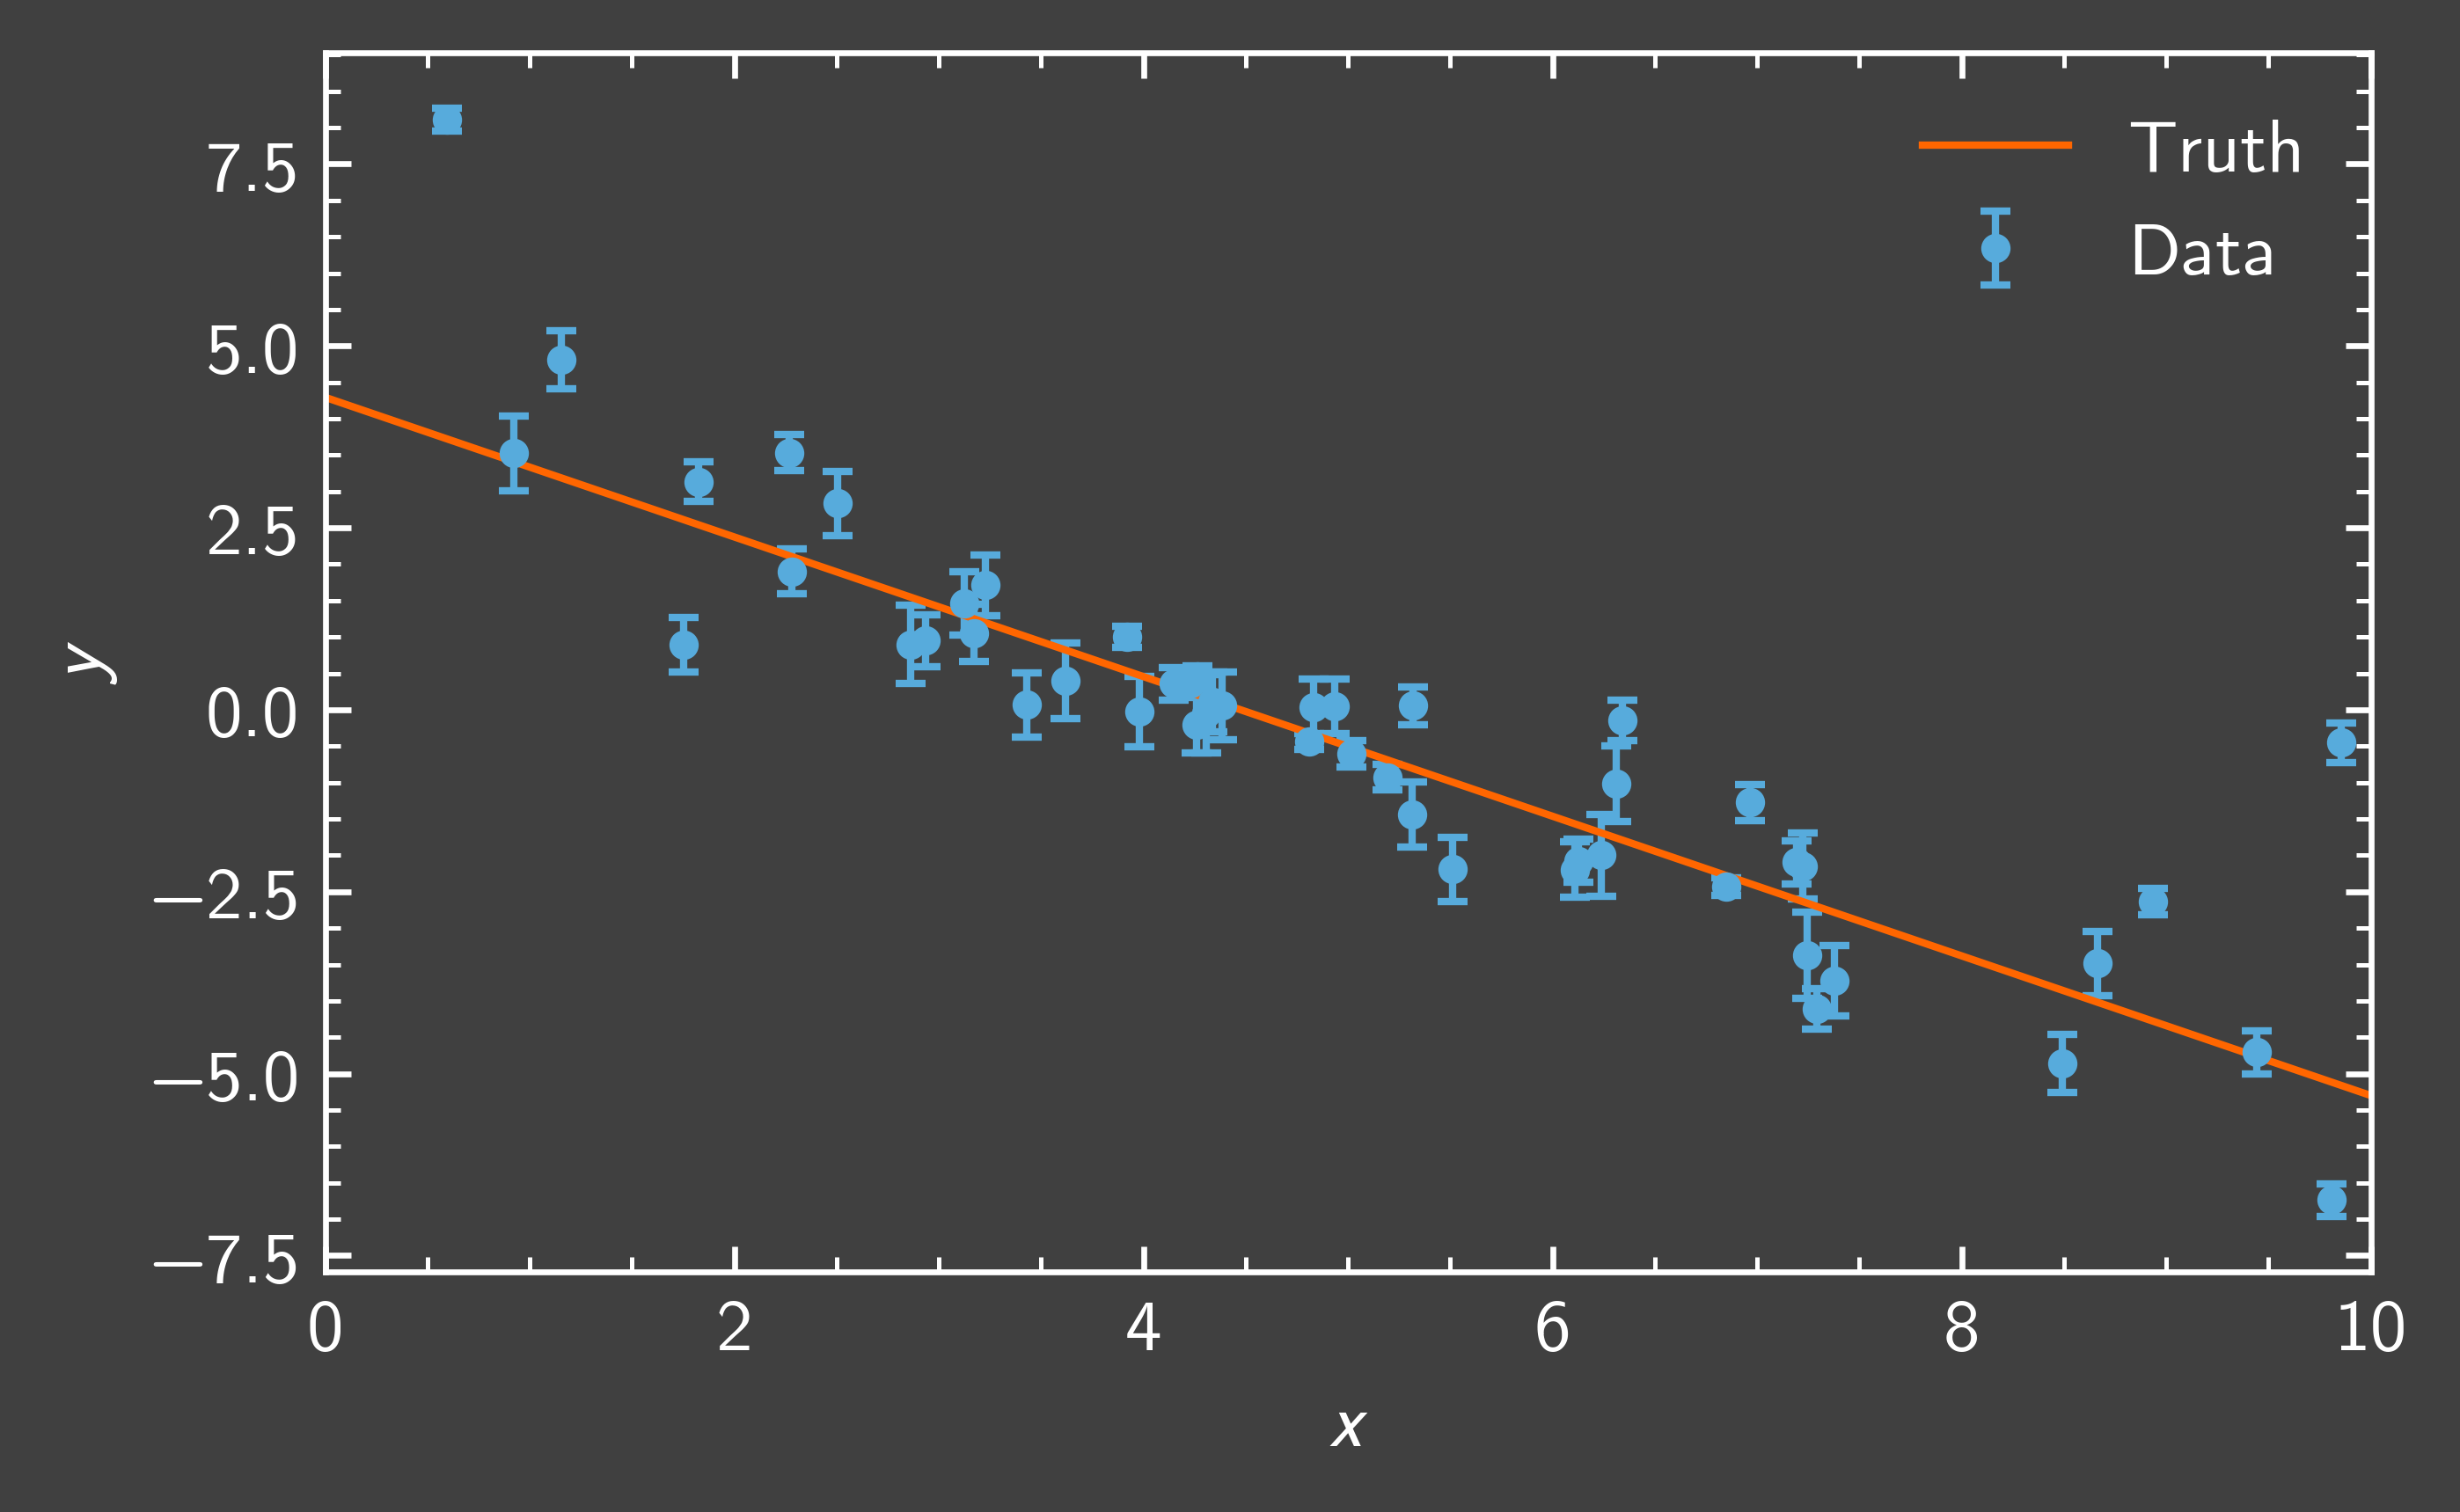

In [3]:
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=2, label="Data", color="#57ABDC")
x0 = np.linspace(0, 10, 1000)
plt.plot(x0, m_true*x0 + b_true, label="Truth", color="#FF6600")
plt.xlim(0,10)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.savefig("data.png", bbox_inches="tight", dpi=300)
plt.show()

## Covariance Matrix
Since we just have a single sample, let's just make a square matrix that has the variances on the diagonal

In [4]:
C = np.diag(yerr * yerr)

then we can use SciPy `curve_fit` to fit a line to the data

In [5]:
from scipy.optimize import curve_fit

def linear_fit(x, m, b):
    return m*x + b

p_0 = (m_true, b_true)
p_opt, p_cov = curve_fit(linear_fit, x, y, p0=p_0, sigma=C)
print("m = {0:.3f} +/- {1:.3f}".format(p_opt[0], np.sqrt(p_cov[0,0])))
print("b = {0:.3f} +/- {1:.3f}".format(p_opt[1], np.sqrt(p_cov[1,1])))

m = -1.104 +/- 0.082
b = 5.441 +/- 0.460


making a graph of the data with the truth and the best fitting line...

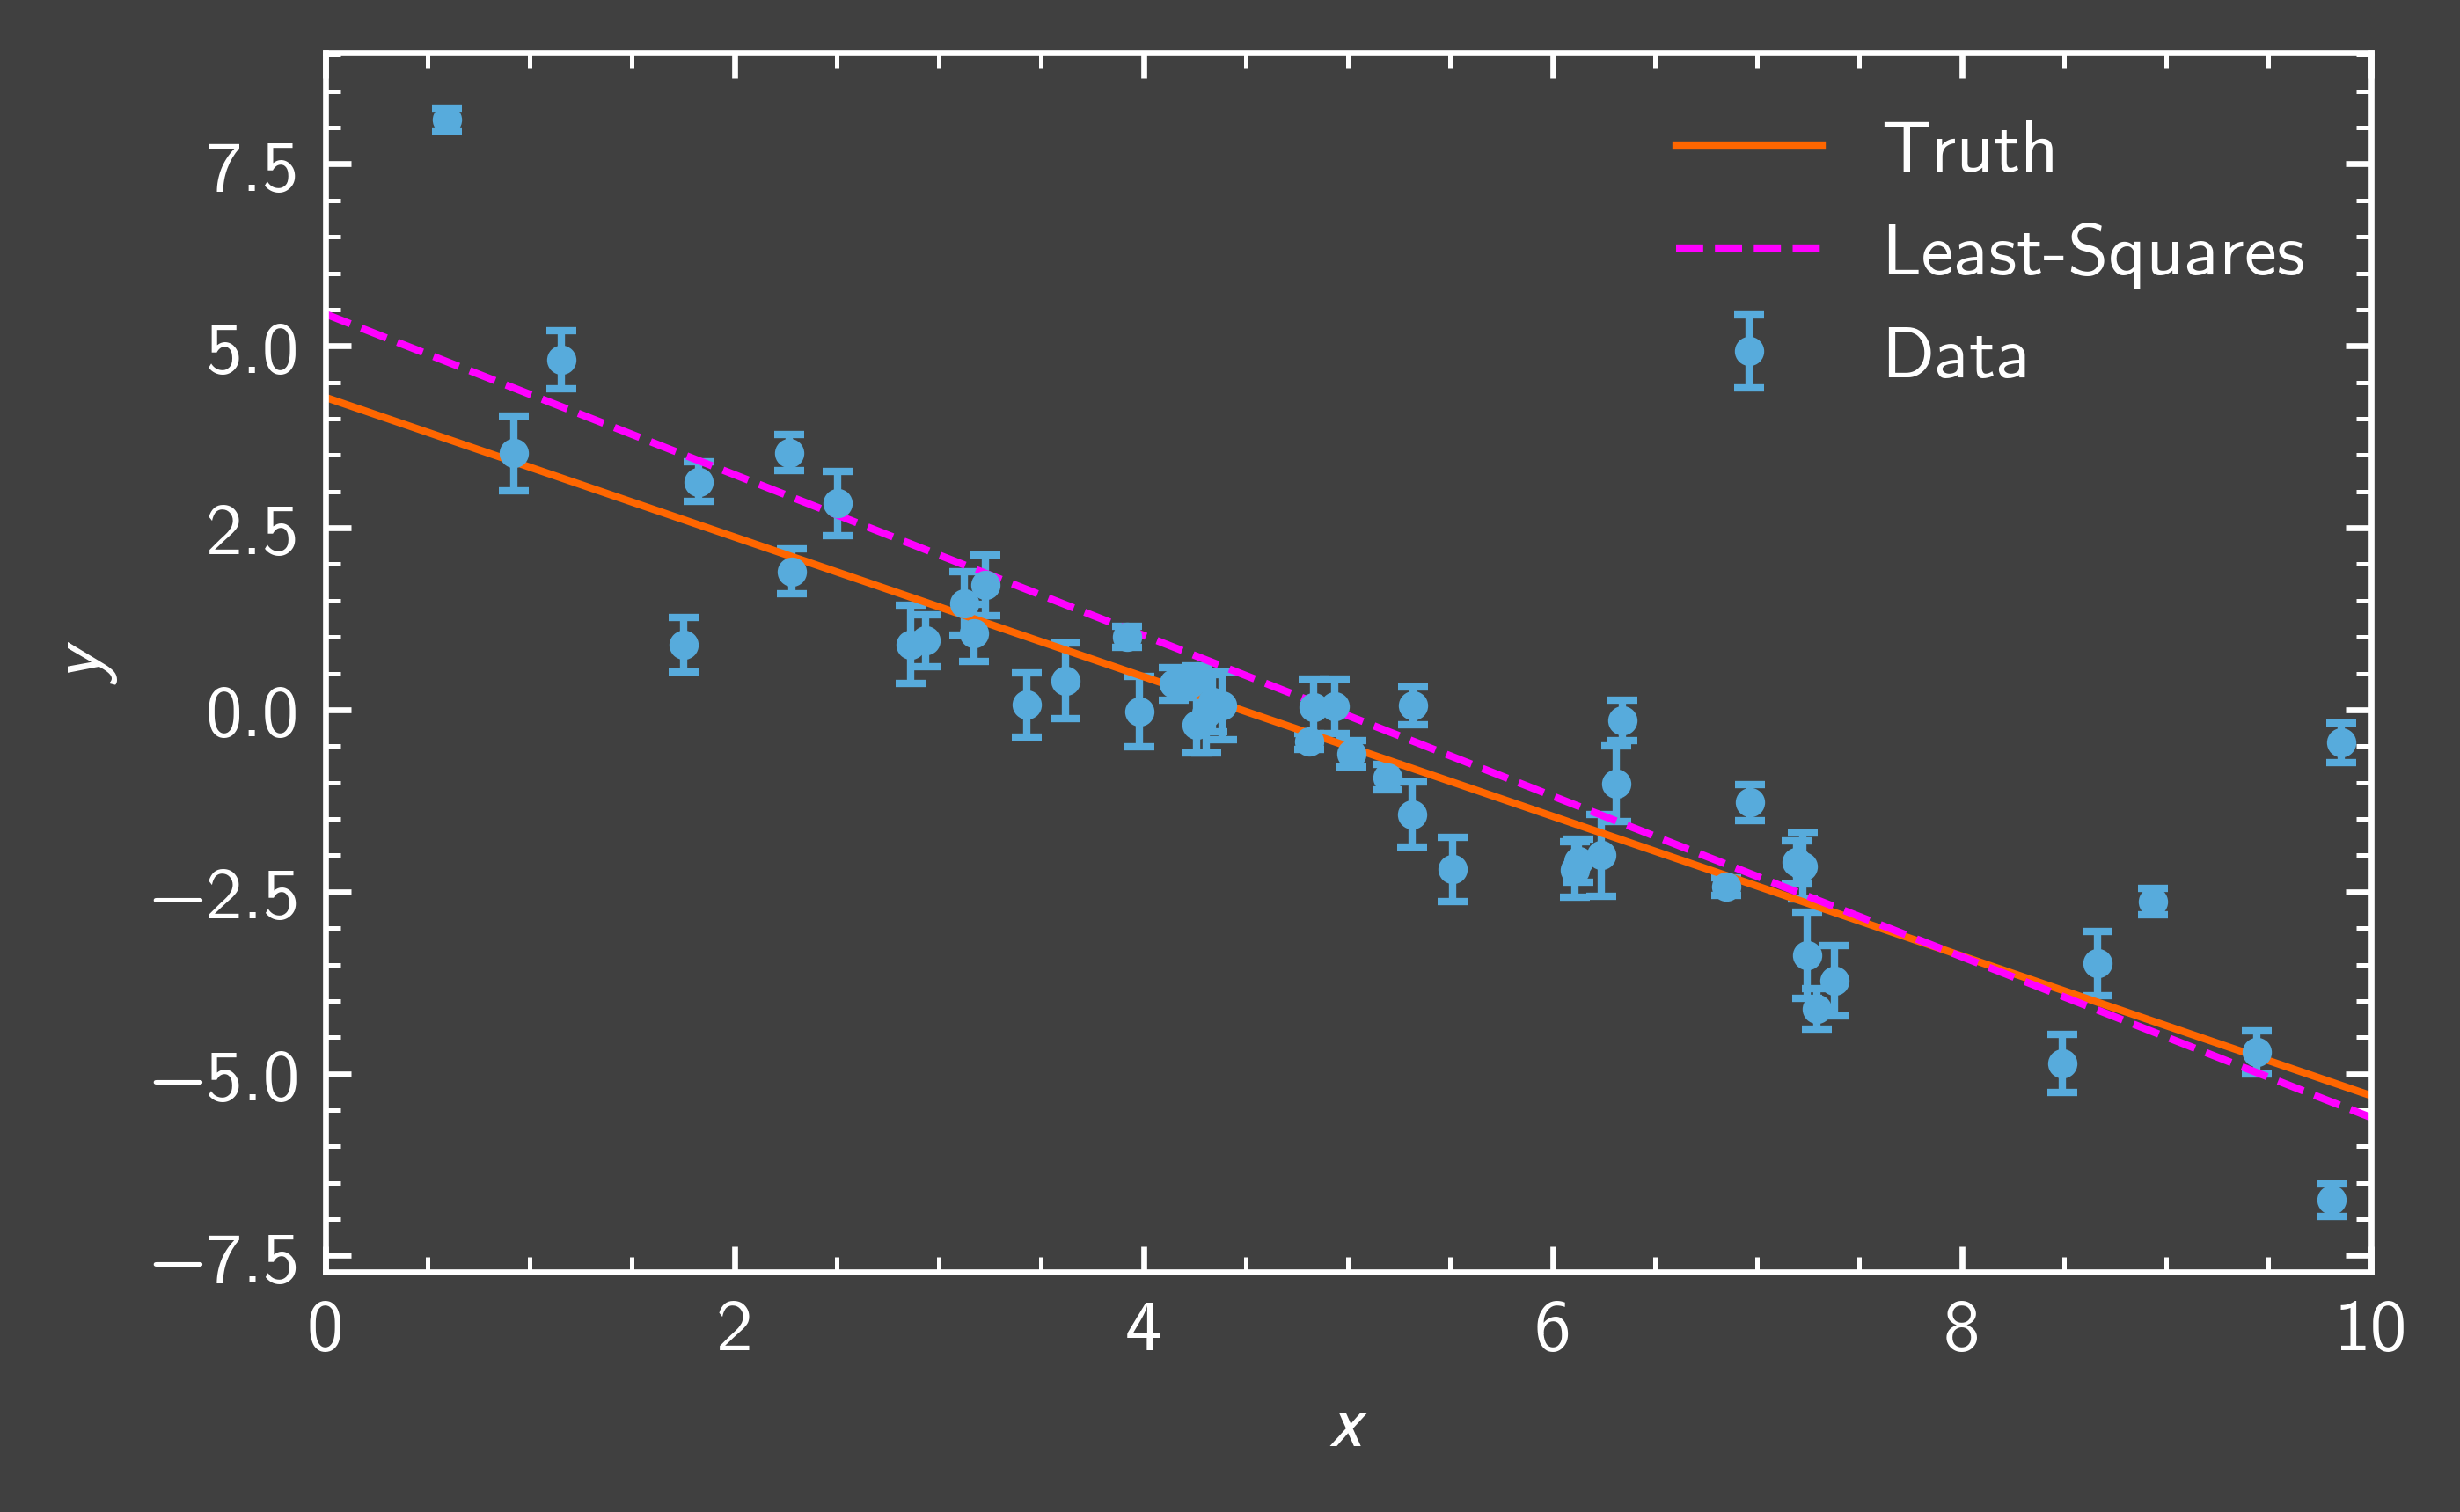

In [6]:
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=2, label="Data", color="#57ABDC")
plt.plot(x0, m_true*x0 + b_true, label="Truth", color="#FF6600")
plt.plot(x0, p_opt[0]*x0 + p_opt[1], label="Least-Squares", color="#FF00FF")
plt.xlim(0,10)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.savefig("least_squares.png", bbox_inches="tight", dpi=300)
plt.show()

## Maximum likelihood
This is another method of finding best fitting parameters. This is often used in conjunction with MCMC.

In [7]:
def neg_log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta # Unpack the parameters
    model = m*x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return 0.5*np.sum((y - model)**2/sigma2 + np.log(sigma2))

now use SciPy `minimize`

In [8]:
from scipy.optimize import minimize

np.random.seed(42) # Again, make sure we get consistent results

# Get initial guesses that are not just the actual values
p_0 = np.array([m_true, b_true, np.log(f_true)]) + 0.1*np.random.normal(0.0, 1.0, 3)
soln = minimize(neg_log_likelihood, p_0, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

# print results
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


Now let's graph the results again...

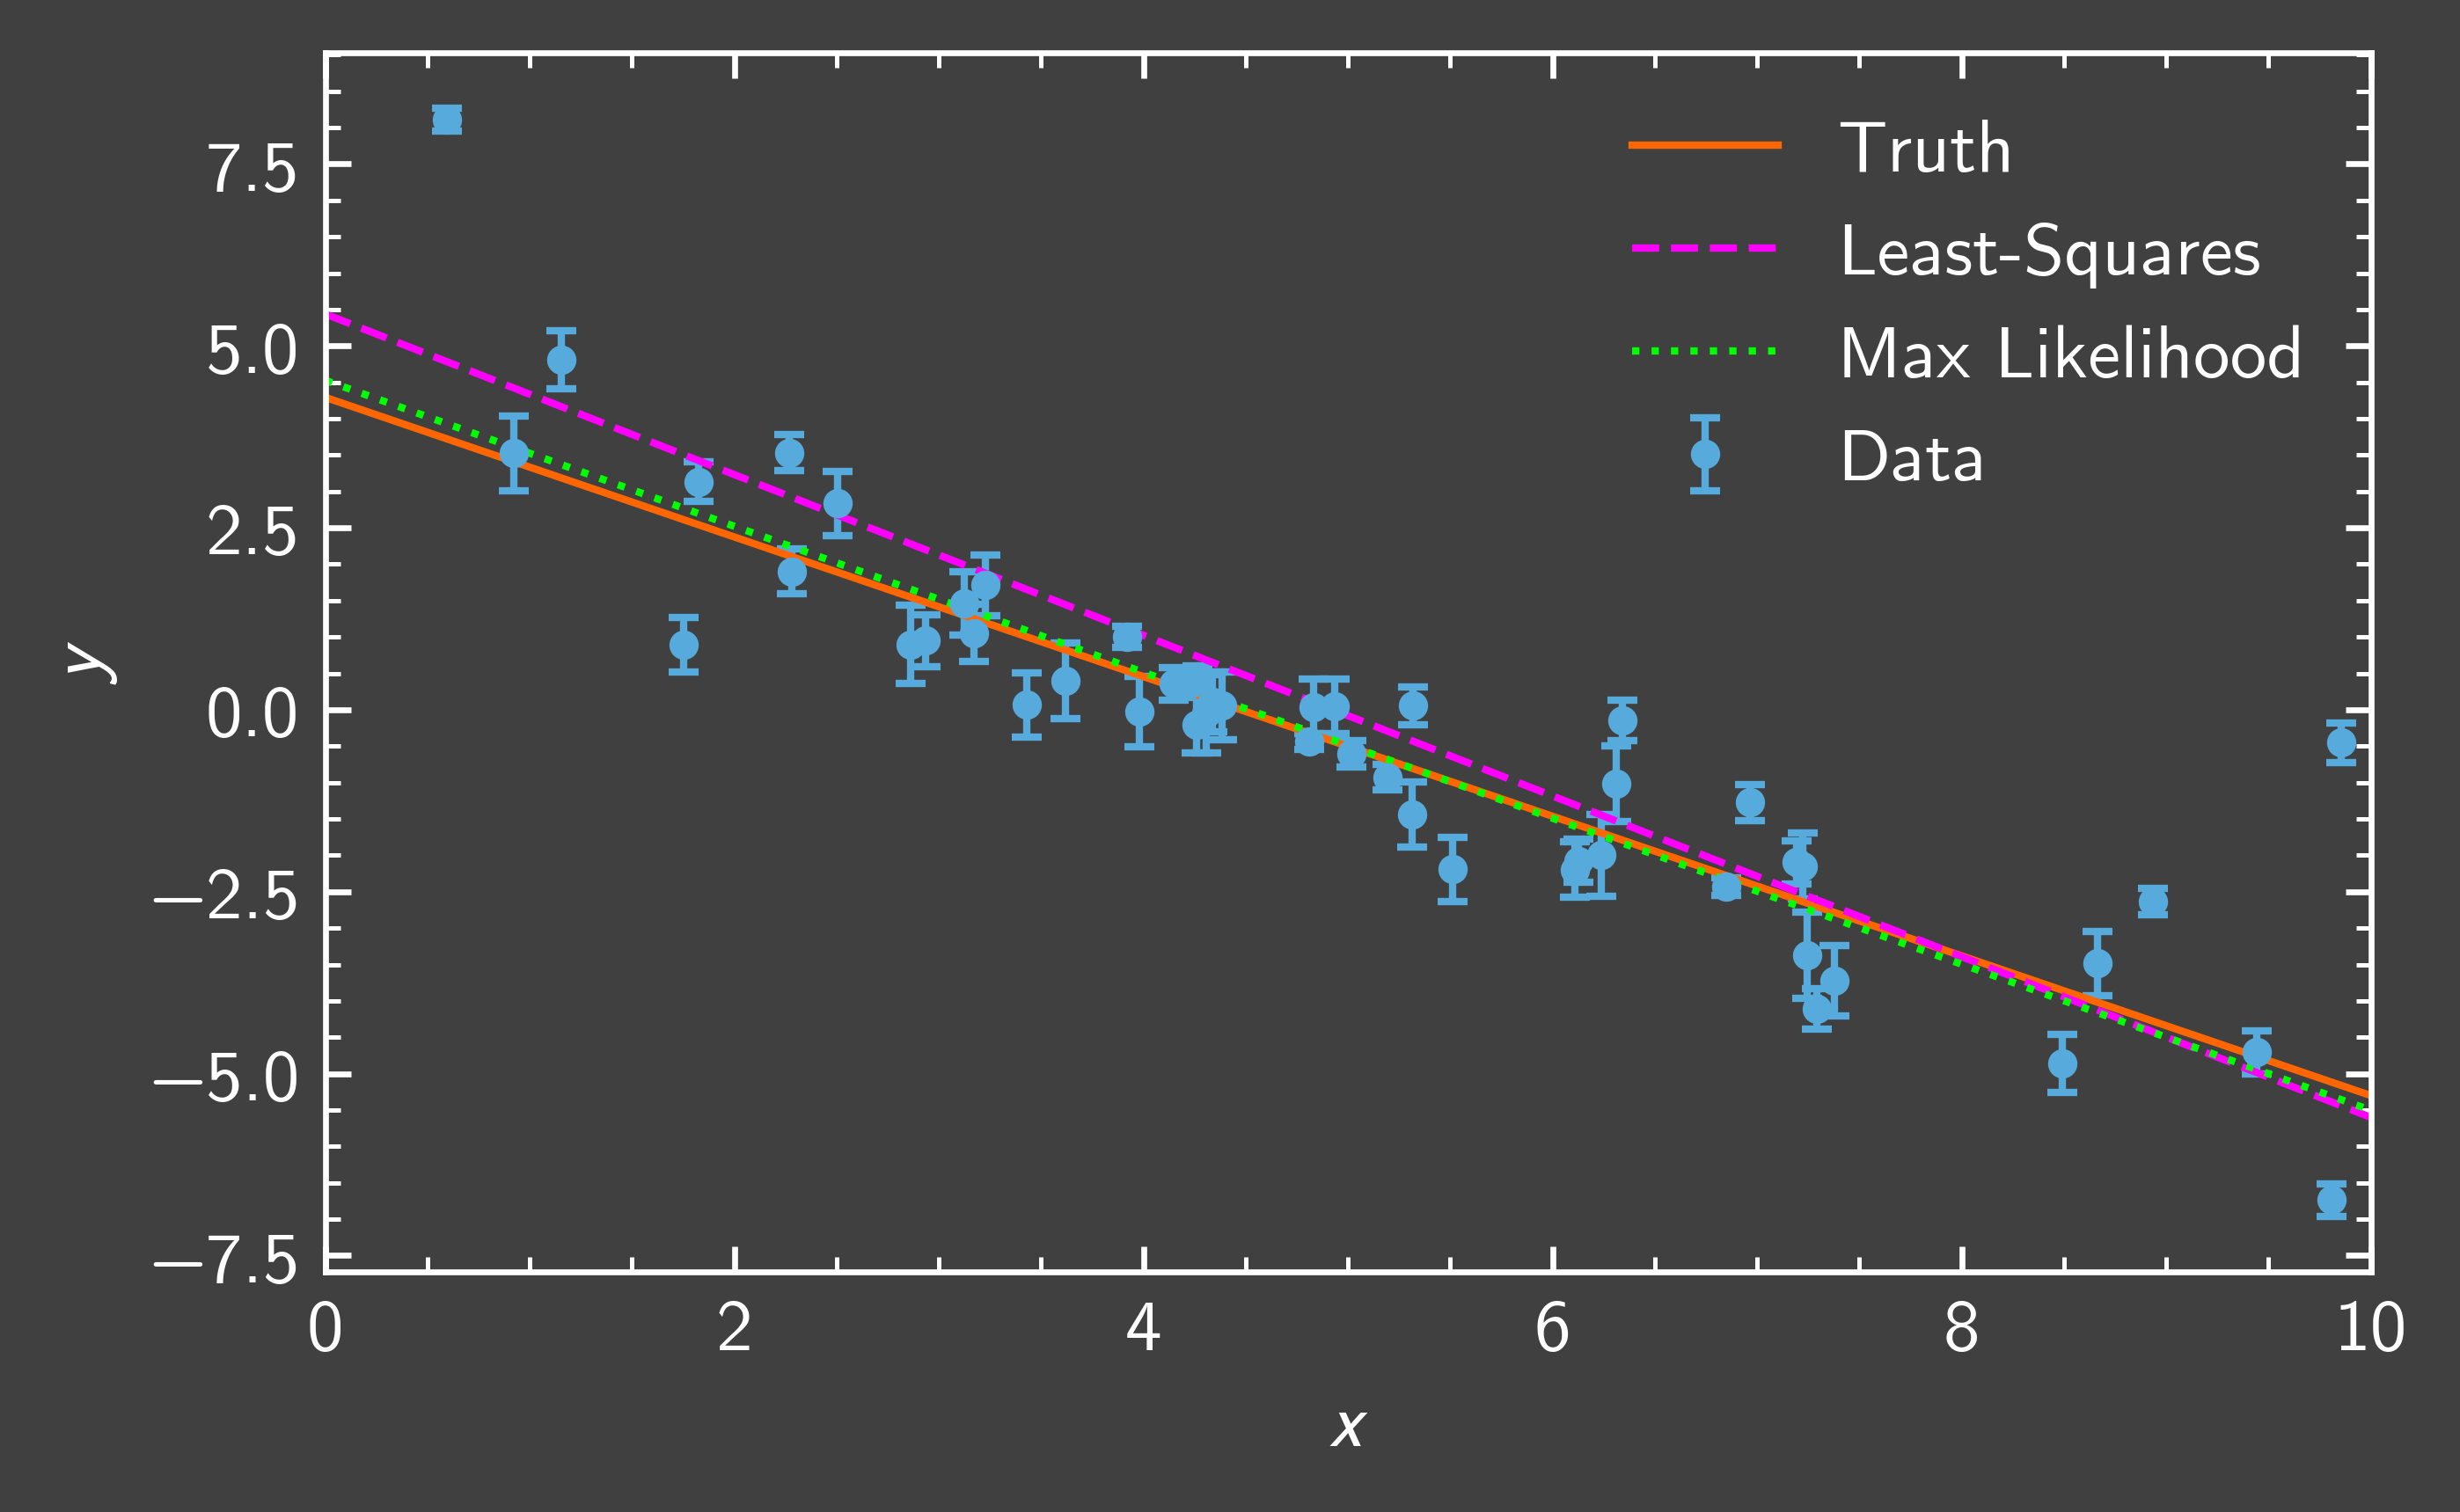

In [9]:
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=2, label="Data", color="#57ABDC")
plt.plot(x0, m_true*x0 + b_true, label="Truth", color="#FF6600")
plt.plot(x0, p_opt[0]*x0 + p_opt[1], label="Least-Squares", color="#FF00FF")
plt.plot(x0, m_ml*x0 + b_ml, label="Max Likelihood", color="#00FF00")
plt.xlim(0,10)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.savefig("max_likelihood.png", bbox_inches="tight", dpi=300)
plt.show()

In [10]:
# I need the data for something. What it is will be a secret...
np.savetxt("data.txt", np.column_stack((x, y, yerr)))

## Finally, MCMC!
Now let's us the emcee library to run the chain!

Define the needed functions...

In [11]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta # Unpack the parameters
    model = m*x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y - model)**2/sigma2 + np.log(sigma2))

then import the emcee library and let it do its thing!

In [12]:
import emcee

# Set the starting position
pos = soln.x + 1e-4 * np.random.randn(32, 3)

# Set the number of walkers (how many simultaneous chains and number of parameters
nwalkers, ndim = pos.shape

# Set up the emcee sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)

# Run the chain
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1811.34it/s]


Now, we want to see how our chain has done.

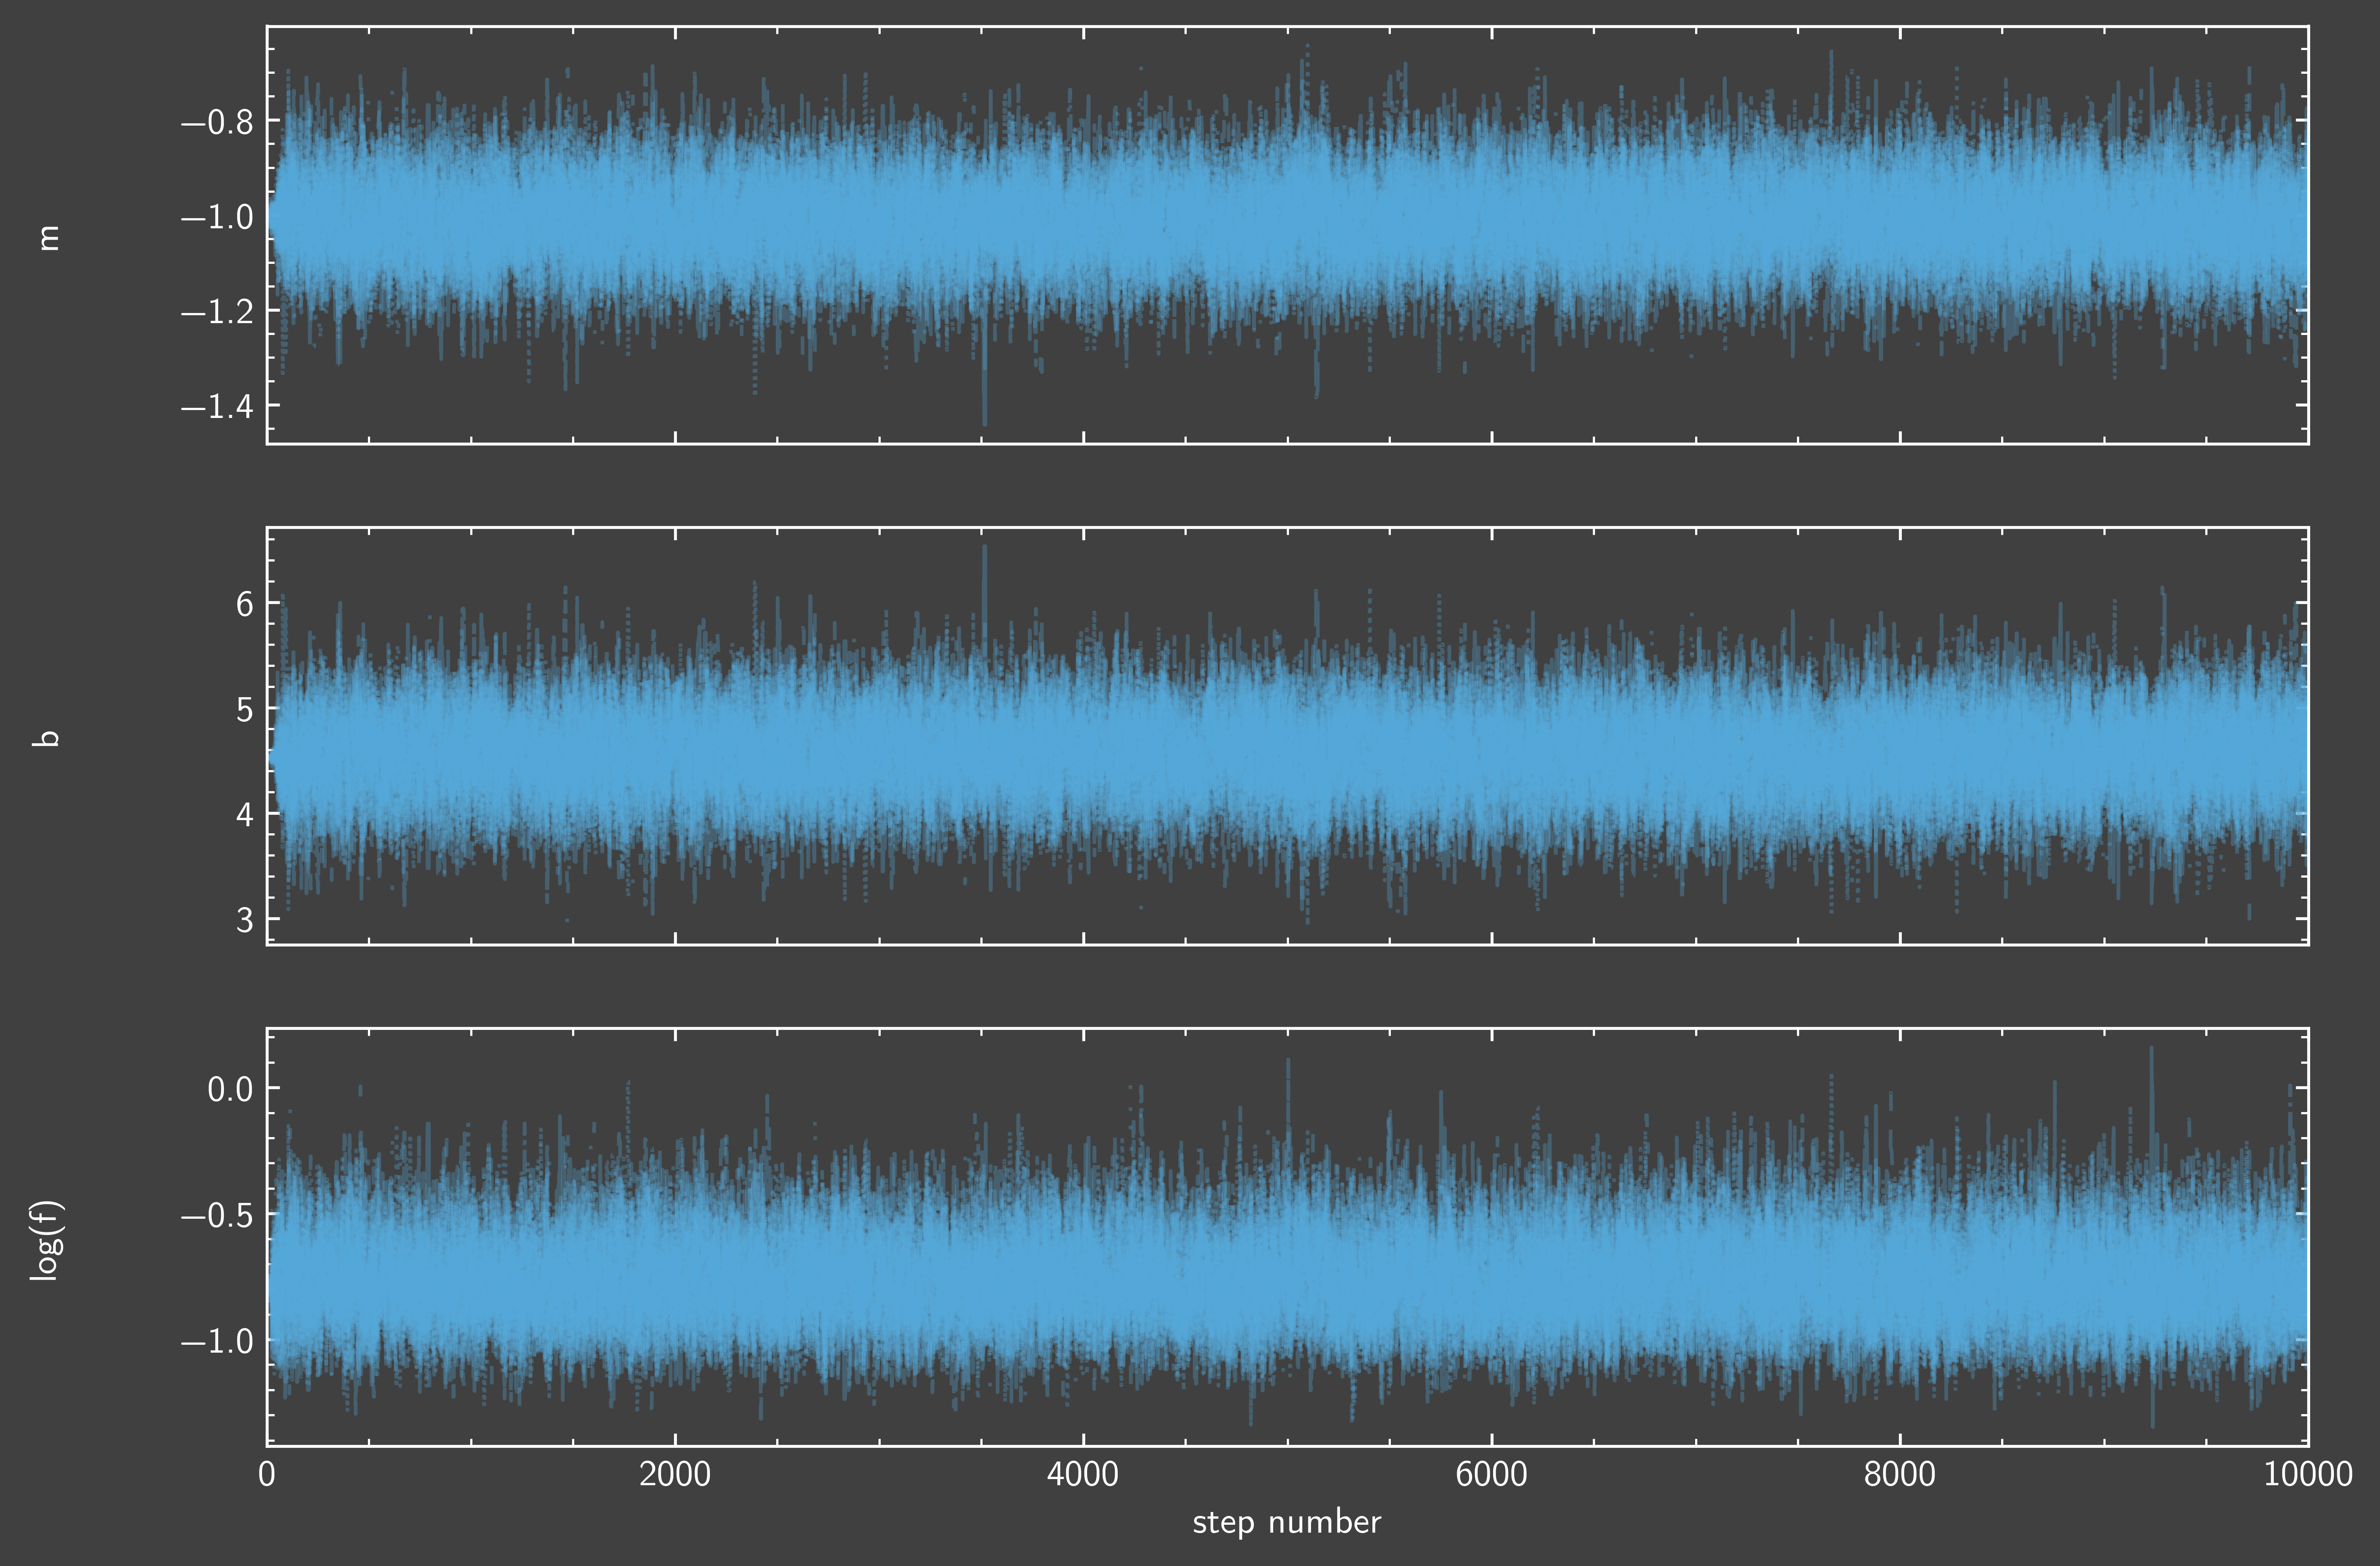

In [16]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3, color="#57ABDC")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.savefig("chain_analysis.pdf", bbox_inches="tight")
plt.show()

There are other things we can look at, but this shows that the chains have "burnt-in".

Now, let's make the corner plot

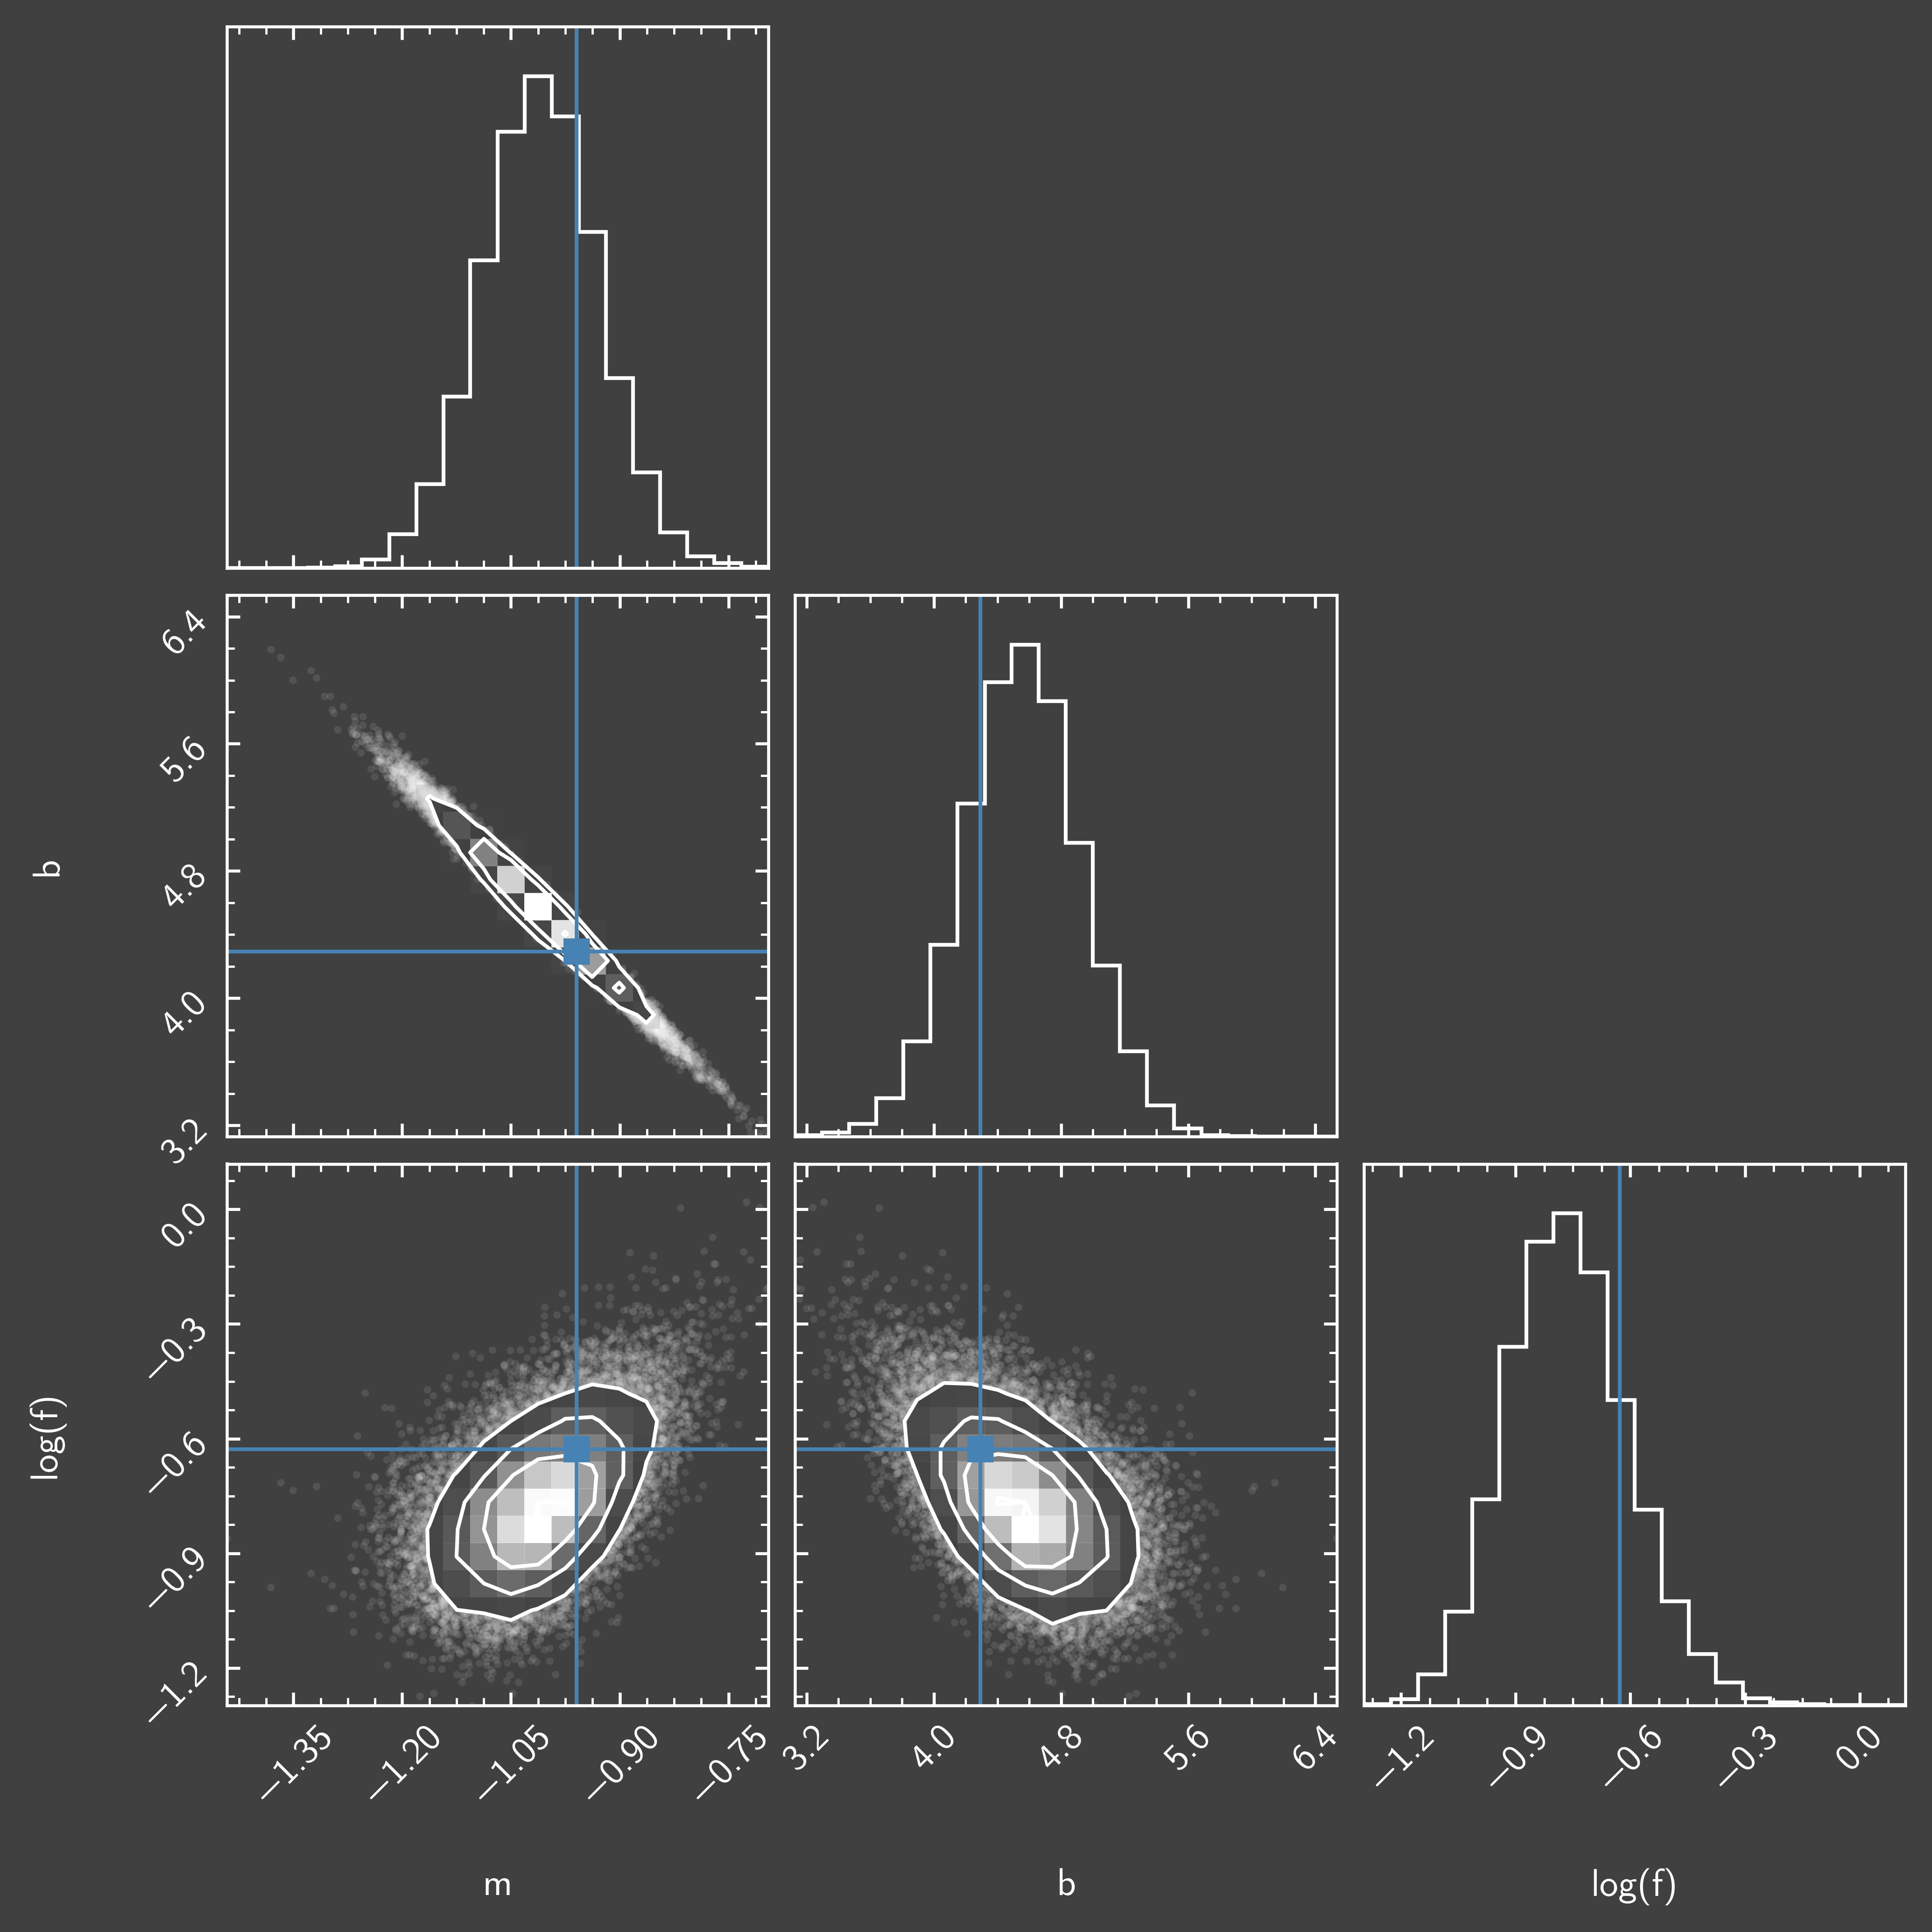

In [18]:
import corner

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)

plt.savefig("corner.pdf", bbox_inches="tight")
plt.show()

Let's now find the values of the *marginalized* uncertainties on our parameters so we can add those to our maximum likelihood estimate of the best-fitting parameters. For this, let's not thin the chains, but we do still want to flatten them, so

In [20]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

(316800, 3)


The we can simply find the average and standard deviation values

In [29]:
m_avg = np.mean(flat_samples.T[0])
b_avg = np.mean(flat_samples.T[1])
f_avg = np.mean(np.exp(flat_samples.T[2]))

sigma_m = np.std(flat_samples.T[0])
sigma_b = np.std(flat_samples.T[1])
sigma_f = np.std(np.exp(flat_samples.T[2]))

print("MCMC estimates:")
print("m = {0:.3f} +/- {1:.3f}".format(m_avg, sigma_m))
print("b = {0:.3f} +/- {1:.3f}".format(b_avg, sigma_b))
print("f = {0:.3f} +/- {1:.3f}".format(f_avg, sigma_f))

MCMC estimates:
m = -1.009 +/- 0.080
b = 4.556 +/- 0.367
f = 0.473 +/- 0.077


To use the standard deviations as uncertainties on our maximum likelihood estimates, we can find the range of values encompassed by $1\sigma$ for each parameter and take differences to get the errors,

In [31]:
m_high = m_avg + sigma_m
m_low = m_avg - sigma_m
m_plus = m_high - m_ml
m_minus = m_ml - m_low

b_high = b_avg + sigma_b
b_low = b_avg - sigma_b
b_plus = b_high - b_ml
b_minus = b_ml - b_low

f_ml = np.exp(log_f_ml)

f_high = f_avg + sigma_f
f_low = f_avg - sigma_f
f_plus = f_high - f_ml
f_minus = f_ml - f_low

print("Maximum Likelihood estimates with MCMC errors:")
print("m = {0:.3f} (+{1:.3f}, -{2:.3f})".format(m_ml, m_plus, m_minus))
print("b = {0:.3f} (+{1:.3f}, -{2:.3f})".format(b_ml, b_plus, b_minus))
print("f = {0:.3f} (+{1:.3f}, -{2:.3f})".format(f_ml, f_plus, f_minus))

Maximum Likelihood estimates with MCMC errors:
m = -1.003 (+0.074, -0.087)
b = 4.528 (+0.395, -0.340)
f = 0.454 (+0.096, -0.058)


Generally, you will see these values report as $m = -1.003_{-0.087}^{+0.074}$, $b = 4.528_{-0.340}^{+0.395}$, and $f = 0.455_{-0.058}^{+0.096}$.